In [1]:
%load_ext autoreload
%config Completer.use_jedi = False

In [156]:
%autoreload 2
import FEMOL
import numpy as np
np.set_printoptions(linewidth=200)
np.set_printoptions(suppress=True)
from IPython.display import clear_output
import matplotlib.pyplot as plt
import matplotlib.tri as tri
from scipy.interpolate import interp1d, griddata, interp2d, RectBivariateSpline
import matplotlib.cm as colormaps
import matplotlib.colors
from mpl_toolkits.axes_grid1 import Divider, Size
import meshio
import time
import runpy

# Development Notebook for the FEMOL Project

In [600]:
# Mean stiffnesses
h_vec = mesh.point_data['zc'].copy()
h_vec[h_area > mesh.point_data['zc']] = h_vec.min()
h_bar = h_vec.mean()

# Optimized layup
plies = [90, 90]
carbon = FEMOL.materials.general_carbon()
layup = FEMOL.laminate.Layup(material=carbon, plies=plies, symetric=False, h_core=0, z_core = h_bar + carbon.hi)
D_mat_coat = layup.D_mat
A_mat_coat = layup.A_mat*0.5
flax = FEMOL.materials.general_flax()
layup2 = FEMOL.laminate.Layup(material=flax, plies=[0,0,0], symetric=True, h_core=0, z_core=0)
D_mat_base = layup2.D_mat
A_mat_base = layup2.A_mat

# reference layup
plies_ref = [90]
h_ref = 0.025
layup_ref1 = FEMOL.laminate.Layup(material=carbon, plies=plies_ref, symetric=False, h_core=0, z_core = h_ref + carbon.hi/2)
D_mat_ref_coat = layup_ref1.D_mat
A_mat_ref_coat = layup_ref1.A_mat




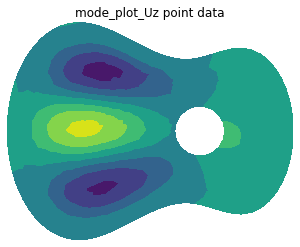

In [44]:
mode_files = ['guitar_mode_T11_lcar04.npy', 'guitar_mode_T21_lcar04.npy', 'guitar_mode_T12_lcar04.npy', 'guitar_mode_T31_lcar04.npy']

T11, T21, T12, T31 = [np.load(modefile) for modefile in mode_files]

problem_mesh.plot.mode(T31)

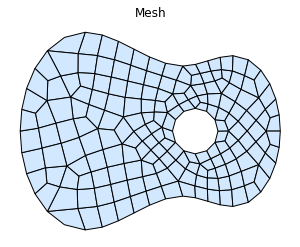

In [8]:
FEMOL.mesh.guitar(lcar=0.09).display()

In [53]:
# Optimization solve
# Solve the eigenvalue maximization problem for the first mode of a square plate

hc_opt = 0.010 # optimized core thickness
h_flax = 0.003
h_carbon = 0.000250
n_plies_carbon = 2
n_plies_flax = 9
problem_mesh = FEMOL.mesh.guitar(lcar=0.09)

# flax material definition
flax = FEMOL.materials.general_flax()  # material from library
flax.hi = h_flax/n_plies_flax
# carbon material definition
carbon = FEMOL.materials.general_carbon()
carbon.hi = h_carbon

# Laminates definitions
h = hc_opt + h_flax + h_carbon
# Reference layups
plies_flax = [0, 0, 0, 0, 0, 0, 0, 0, 0]
flax_layup = FEMOL.laminate.Layup(material=flax, plies=plies_flax, symetric=False, z_core = -h/2 + (n_plies_flax/2)*flax.hi)
plies_carbon = [90, 90]
carbon_layup = FEMOL.laminate.Layup(material=carbon, plies=plies_carbon, symetric=False, z_core = h/2 - (n_plies_carbon/2)*carbon.hi)

# FEM problems definition
problem_opt = FEMOL.FEM_Problem(mesh=problem_mesh, physics='modal', model='plate')
problem_opt.define_materials(flax, carbon)
problem_opt.define_tensors(flax_layup, carbon_layup)
problem_opt.add_fixed_domain(FEMOL.domains.outside_guitar(L=1))

# Solve the reference problem
w_opt, v_opt = problem_opt.solve(filtre=0)


solving using scipy
solved in :  11.036695003509521  s


In [60]:
np.arange(w_opt.shape[0])[w_opt>1][-1]

774

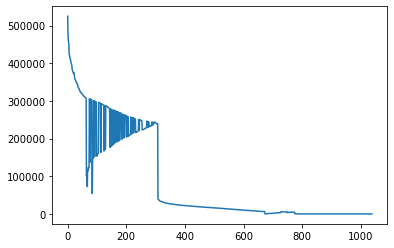

In [56]:
plt.plot(w_opt)

In [51]:
mode_vectors = [np.load(f) for f in [f'guitar_mode_{m}_lcar05.npy' for m in ['T11', 'T21', 'T13', 'T31']]]

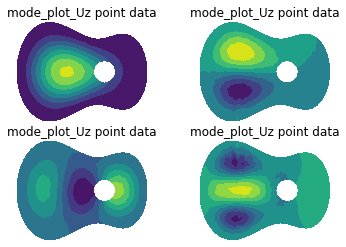

In [57]:
fig, axs = plt.subplots(2,2)

plt.sca(axs[0][0])
problem_mesh.plot.mode(mode_vectors[0])
plt.sca(axs[0][1])
problem_mesh.plot.mode(mode_vectors[1])
plt.sca(axs[1][0])
problem_mesh.plot.mode(mode_vectors[2])
plt.sca(axs[1][1])
problem_mesh.plot.mode(mode_vectors[3])

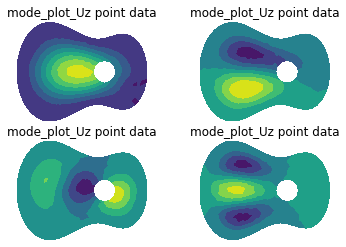

In [59]:
mode_indexes = [np.argmax([FEMOL.utils.MAC(vref, vi) for vi in v_opt]) for vref in mode_vectors]

fig, axs = plt.subplots(2,2)
axs = axs.flatten()
for i in range(4):
    plt.sca(axs[i])
    problem_mesh.plot.mode(v_opt[mode_indexes[i]])


In [ ]:

# Load the MAC eigenvector
vector_mac = np.load('guitar_mode_T11_lcar09.npy')

# Solve the eigenvalue maximization of the first mode
SIMP = FEMOL.SIMP_VIBE(Problem=problem_opt, objective='max eig')
mesh = SIMP.solve(vector_mac, save=True, plot=True, converge=0.05)


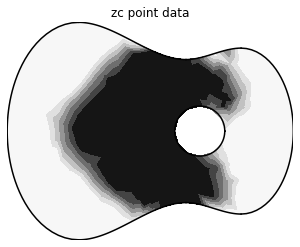

In [162]:
mesh = FEMOL.mesh.load_vtk('Results/_topopt_cache/TOM_2022-03-14_21_08_39.vtk')
mesh.cell_to_point_data('zc')
mesh.plot.point_data('zc', cmap='Greys')
FEMOL.utils.guitar_outline2(L=1)

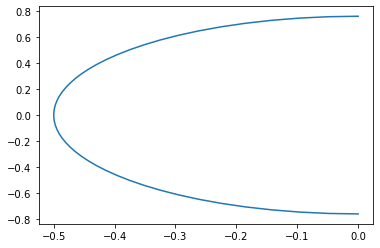

In [150]:
theta = np.linspace(np.pi/2, 3*np.pi/2)
a, b = 0.50 * L, 0.76 * L
r = (a*b)/np.sqrt((b*np.cos(theta))**2 + (a*np.sin(theta))**2)
x = r*np.cos(theta)
y = r*np.sin(theta)

plt.plot(x, y)
